## 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('bmh')

## 2. Exploratory data analysis

In [2]:
train_set = pd.read_csv('train_set.csv', delimiter = ';')
train_set.head()

,client_id,target
0,75063019,0
1,86227647,1
2,6506523,0
3,50615998,0
4,95213230,0


In [3]:
# dataset is not disbalanced
train_set.describe()

,client_id,target
count,6.000000e+03,6000.000000
mean,5.102984e+07,0.443333
std,2.881391e+07,0.496820
min,2.289900e+04,0.000000
25%,2.612906e+07,0.000000
50%,5.164080e+07,0.000000
75%,7.590927e+07,1.000000
max,9.999124e+07,1.000000


In [4]:
test_set = pd.read_csv('test_set.csv', delimiter = ';')
test_set.head()

,client_id
0,61240380
1,34114030
2,15926722
3,50598019
4,76475250


In [5]:
test_set.shape

(2656, 1)

In [6]:
transactions = pd.read_csv('transactions.csv', delimiter = ';')
transactions.head()

,client_id,datetime,code,type,sum
0,96372458,421 06:33:15,6011,2010,-561478.94
1,24567813,377 17:20:40,6011,7010,67377.47
2,21717441,55 13:38:47,6011,2010,-44918.32
3,14331004,263 12:57:08,6011,2010,-3368873.66
4,85302434,151 10:34:12,4814,1030,-3368.87


In [7]:
transactions.describe()

,client_id,code,type,sum
count,1.300390e+05,130039.000000,130039.000000,1.300390e+05
mean,5.086859e+07,5594.629996,2489.372135,-1.812909e+04
std,2.872854e+07,606.087084,2253.296578,5.584445e+05
min,2.289900e+04,742.000000,1000.000000,-4.150030e+07
25%,2.577174e+07,5211.000000,1030.000000,-2.244916e+04
50%,5.235837e+07,5641.000000,1110.000000,-5.502490e+03
75%,7.506302e+07,6010.000000,2370.000000,-1.122960e+03
max,9.999968e+07,9402.000000,8145.000000,6.737747e+07


In [8]:
types = pd.read_csv('types.csv', delimiter = ';')
types.head()

,type,type_description
0,8001,Установление расх. лимита по карте
1,2411,Перевод с карты на счет др.лица в одном тер. б...
2,4035,н/д(нет данных)
3,3001,Комиссия за обслуживание ссудного счета
4,2420,Перевод с карты на счет физ.лица в другом тер....


In [9]:
types.shape

(155, 2)

In [10]:
codes = pd.read_csv('codes.csv', delimiter = ';')
codes.head()

,code,code_description
0,5944,"Магазины по продаже часов, ювелирных изделий и..."
1,5621,Готовые сумочные изделия
2,5697,"Услуги по переделке, починке и пошиву одежды"
3,7995,Транзакции по азартным играм
4,5137,"Мужская, женская и детская спец-одежда"


In [11]:
codes.shape

(184, 2)

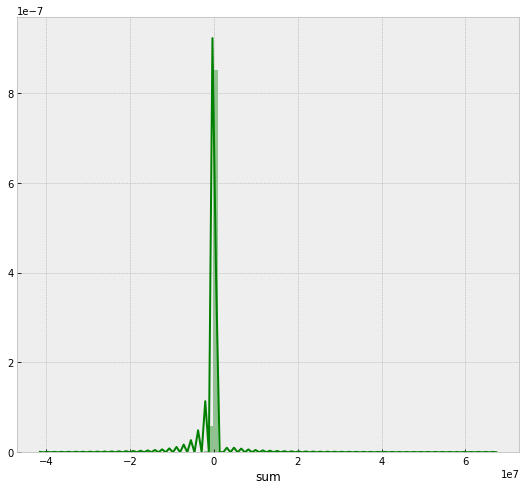

In [12]:
plt.figure(figsize=(9, 8))
sns.distplot(transactions['sum'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [13]:
popular_types = transactions['type'].value_counts()[:20]
print(popular_types)

1010    30802
2010    20204
1030    18368
1110    17648
7070    12915
2370     6848
7010     4989
7030     2860
1100     2232
1200     1797
7071     1538
2330     1370
4071     1175
2371     1170
2011     1139
4010      583
7031      568
6110      409
4051      393
2331      390
Name: type, dtype: int64


In [14]:
popular_codes = transactions['code'].value_counts()[:20]
print(popular_codes)

6011    27917
6010    18684
4814    18641
5411    18490
4829    11423
5499     6480
5912     2685
5541     2672
5331     2518
5812     2052
5814     1766
5999     1108
5921     1094
5311      708
5977      676
5964      630
5983      577
5211      564
5691      527
7995      469
Name: code, dtype: int64


## Feature engineering

In [15]:
# total sum of transactions
aggregated = transactions.groupby("client_id").sum().drop(columns = ['code','type'])
print(aggregated)

                  sum
client_id            
22899        50847.54
27914        74115.21
28753     -2589800.29
31385       -83525.38
38084       693495.66
...               ...
99967537   -336887.37
99984336     78607.06
99985917   -224591.58
99991245    569609.16
99999680   -651595.19

[8656 rows x 1 columns]


In [16]:
aggregated_1 = transactions.groupby("client_id").count().drop(columns = ['code','type', 'datetime']).rename(columns={'sum': 'count_transactions'})
aggregated = pd.concat([aggregated, aggregated_1], axis=1, join="outer")
print(aggregated)

                  sum  count_transactions
client_id                                
22899        50847.54                   9
27914        74115.21                   4
28753     -2589800.29                  13
31385       -83525.38                  13
38084       693495.66                  26
...               ...                 ...
99967537   -336887.37                   1
99984336     78607.06                   4
99985917   -224591.58                   1
99991245    569609.16                   4
99999680   -651595.19                  15

[8656 rows x 2 columns]


In [17]:
# features with most popular code and type
buffer = transactions.groupby("client_id").median().drop(columns = 'sum')

In [18]:
predictors = pd.concat([aggregated, buffer], axis=1, join="outer")
predictors = predictors.rename(columns={'sum': 'sum_of_transactions', 'code': 'most_common_code', 'type': 'most_common_type'})
predictors['most_common_code'] = predictors['most_common_code'].astype("category")
predictors['most_common_type'] = predictors['most_common_type'].astype("category")
print(predictors)

           sum_of_transactions  count_transactions most_common_code  \
client_id                                                             
22899                 50847.54                   9           6010.0   
27914                 74115.21                   4           5412.0   
28753              -2589800.29                  13           5661.0   
31385                -83525.38                  13           5411.0   
38084                693495.66                  26           5411.0   
...                        ...                 ...              ...   
99967537            -336887.37                   1           6011.0   
99984336              78607.06                   4           6011.0   
99985917            -224591.58                   1           6011.0   
99991245             569609.16                   4           5755.0   
99999680            -651595.19                  15           5541.0   

          most_common_type  
client_id                   
22899             

In [19]:
# average hour of transaction
from datetime import datetime

time = transactions.drop(columns = ['code', 'type'])
time['day_number'] = transactions['datetime'].str[:3]
time['time'] = transactions['datetime'].str[-8:].str[:2]
time['time'] = time['time'].astype(int)
time.head()

,client_id,datetime,sum,day_number,time
0,96372458,421 06:33:15,-561478.94,421,6
1,24567813,377 17:20:40,67377.47,377,17
2,21717441,55 13:38:47,-44918.32,55,13
3,14331004,263 12:57:08,-3368873.66,263,12
4,85302434,151 10:34:12,-3368.87,151,10


In [20]:
buffer_1 = time.drop(columns = ['sum', 'day_number', 'datetime']).groupby("client_id").mean()
buffer_1 = buffer_1.rename(columns={'time': 'mean_hour'})
buffer_1.head()
predictors = pd.merge(predictors, buffer_1, on = 'client_id', how ="left")
print(predictors)

           sum_of_transactions  count_transactions most_common_code  \
client_id                                                             
22899                 50847.54                   9           6010.0   
27914                 74115.21                   4           5412.0   
28753              -2589800.29                  13           5661.0   
31385                -83525.38                  13           5411.0   
38084                693495.66                  26           5411.0   
...                        ...                 ...              ...   
99967537            -336887.37                   1           6011.0   
99984336              78607.06                   4           6011.0   
99985917            -224591.58                   1           6011.0   
99991245             569609.16                   4           5755.0   
99999680            -651595.19                  15           5541.0   

          most_common_type  mean_hour  
client_id                           

In [21]:
# feature payments for calls
buffer_2 = transactions.groupby('client_id')['code'].apply(lambda x: (x == 4814).sum()).reset_index(name='transactions_calls')
predictors = pd.merge(predictors, buffer_2, on = 'client_id', how ="left")
print(predictors)

      client_id  sum_of_transactions  count_transactions most_common_code  \
0         22899             50847.54                   9           6010.0   
1         27914             74115.21                   4           5412.0   
2         28753          -2589800.29                  13           5661.0   
3         31385            -83525.38                  13           5411.0   
4         38084            693495.66                  26           5411.0   
...         ...                  ...                 ...              ...   
8651   99967537           -336887.37                   1           6011.0   
8652   99984336             78607.06                   4           6011.0   
8653   99985917           -224591.58                   1           6011.0   
8654   99991245            569609.16                   4           5755.0   
8655   99999680           -651595.19                  15           5541.0   

     most_common_type  mean_hour  transactions_calls  
0              4010.

In [22]:
train_set = pd.merge(train_set, predictors, on = 'client_id', how ="left")
print(train_set)

      client_id  target  sum_of_transactions  count_transactions  \
0      75063019       0             89032.60                  29   
1      86227647       1           -606058.60                  27   
2       6506523       0           2635753.74                  53   
3      50615998       0            -42672.40                   7   
4      95213230       0            214292.66                  34   
...         ...     ...                  ...                 ...   
5995   71577803       0           -114601.90                   5   
5996    8128547       1           -262708.36                   7   
5997   26055781       0            -42863.31                   6   
5998   73504380       1            -75992.84                  19   
5999    1846496       0            -16392.05                  10   

     most_common_code most_common_type  mean_hour  transactions_calls  
0              5411.0           1110.0  15.068966                   5  
1              5411.0           1110.0 

## Feature selection, cross-validation, implementation of one algorithm 

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(train_set.drop(columns = ['target', 'client_id']), train_set['target'], 
                                                    test_size=0.33, 
                                                    random_state=42)


from sklearn.pipeline import Pipeline

#this is the classifier used for feature selection
clf_featr_sele = RandomForestClassifier(n_estimators=30, 
                                        random_state=42,
                                        class_weight="balanced") 
rfecv = RFECV(estimator=clf_featr_sele, 
              step=1, 
              cv=5, 
              scoring = 'roc_auc')

#you can have different classifier for your final classifier
clf = RandomForestClassifier(n_estimators=50, 
                             random_state=42,
                             class_weight="balanced",
                             max_features = 2) 
CV_rfc = GridSearchCV(clf, 
                      param_grid={'max_depth':[2,3]},
                      cv= 5, refit='AUC', return_train_score=True,
                      verbose=3)

pipeline  = Pipeline([('feature_sele',rfecv),
                      ('clf_cv',CV_rfc)], verbose=3)

pipeline.fit(X_train, y_train)

[Pipeline] ...... (step 1 of 2) Processing feature_sele, total=   3.6s
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] max_depth=2 .....................................................
[CV] ..... max_depth=2, score=(train=0.590, test=0.586), total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ..... max_depth=2, score=(train=0.590, test=0.595), total=   0.1s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ..... max_depth=2, score=(train=0.594, test=0.531), total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ..... max_depth=2, score=(train=0.604, test=0.572), total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ..... max_depth=2, score=(train=0.599, test=0.560), total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ..... max_depth=3, score=(train=0.599, test=0.591), total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ..... max_depth=3, score=(train=0.604, test=0.601), total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ..... max_depth=3, score=(train=0.611, test=0.552), total=   0.1s
[CV] max_depth=3 .....................................................
[CV] ..... max_depth=3, score=(train=0.618, test=0.571), total=   0.1s
[CV] max_depth=3 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


Pipeline(memory=None,
         steps=[('feature_sele',
                 RFECV(cv=5,
                       estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced',
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
 

In [24]:
CV_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [25]:
# Far from ideal, but this is 24 hour task.
CV_rfc.best_score_

0.5753731343283581

In [26]:
del aggregated
del aggregated_1
del buffer
del buffer_1
del buffer_2

## Prediction

In [27]:
test_set = pd.merge(test_set, predictors, on = 'client_id', how ="left").drop(columns = 'client_id')

In [28]:
test_set.head()

,sum_of_transactions,count_transactions,most_common_code,most_common_type,mean_hour,transactions_calls
0,-245029.43,15,5411.0,1010.0,8.333333,2
1,170464.33,3,6011.0,2010.0,14.000000,0
2,-406510.75,3,6011.0,2010.0,14.000000,0
3,-102308.88,31,5921.0,1010.0,12.677419,2
4,-5836986.22,37,5812.0,1030.0,12.486486,2


In [39]:
score = pipeline.predict(test_set).astype(int)
np.savetxt("score.csv", score, delimiter=";")

In [38]:
score

array([0, 0, 1, ..., 1, 0, 0])